<a href="https://colab.research.google.com/github/LauraGeiger/Cerebellar-Learning/blob/main/NEURON_STDP_LTP_LTD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install neuron

In [2]:
from neuron import h, gui
import numpy as np
import matplotlib.pyplot as plt

# To be removed

In [3]:
# Create a single compartment (a soma)
soma = h.Section(name='soma')
soma.L = 20   # Length in microns
soma.diam = 20  # Diameter in microns

# Insert passive properties (leakage channels)
soma.insert('pas')
soma.g_pas = 0.0001  # Passive conductance
soma.e_pas = -65  # Resting potential (mV)

print("Soma created with length:", soma.L, "and diameter:", soma.diam)

Soma created with length: 20.0 and diameter: 20.0


In [4]:
soma.insert('hh')  # Insert Hodgkin-Huxley channels


soma

In [5]:
stim = h.IClamp(soma(0.5))  # Place at the center of the soma
stim.delay = 5   # Start stimulation at 5 ms
stim.dur = 1     # Lasts for 1 ms
stim.amp = 0.1   # Current amplitude in nA


In [6]:
v = h.Vector()  # Create a vector to store voltage
t = h.Vector()  # Create a vector to store time

v.record(soma(0.5)._ref_v)  # Record from the center of soma
t.record(h._ref_t)  # Record time

h.finitialize(-65)  # Initialize at resting potential
h.continuerun(40)   # Run simulation for 40 ms


0.0

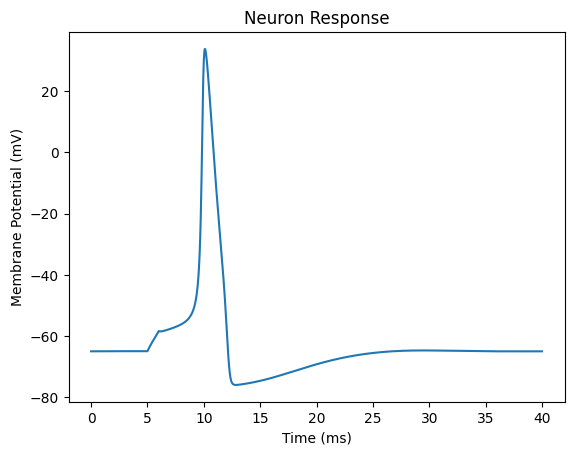

In [7]:
import matplotlib.pyplot as plt

plt.plot(t, v)
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.title('Neuron Response')
plt.show()


Initial synaptic weight: 0.01


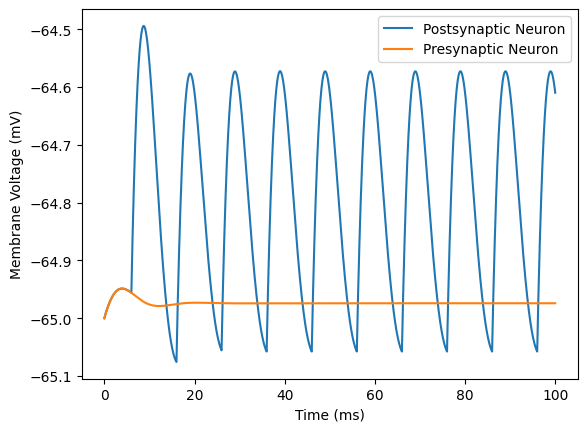

Final synaptic weight: 0.01


In [9]:
from neuron import h, gui
import numpy as np
import matplotlib.pyplot as plt

# Create two neurons: presynaptic and postsynaptic
pre_neuron = h.Section(name='pre_neuron')
post_neuron = h.Section(name='post_neuron')

# Insert Hodgkin-Huxley mechanism
pre_neuron.insert('hh')
post_neuron.insert('hh')

# Create a synapse on the postsynaptic neuron
syn = h.ExpSyn(post_neuron(0.5))
syn.tau = 5  # Decay time (ms)

# Create a NetStim to generate presynaptic spikes
stim = h.NetStim()
stim.start = 5   # First spike at 5 ms
stim.number = 10  # Number of spikes
stim.interval = 10  # Spike interval (ms)

# Connect the stimulator to the synapse via NetCon
nc = h.NetCon(stim, syn)
nc.weight[0] = 0.01  # Initial synaptic weight
nc.delay = 1  # Delay in ms

print("Initial synaptic weight:", nc.weight[0])

# Record membrane potential
v_pre = h.Vector().record(pre_neuron(0.5)._ref_v)
v_post = h.Vector().record(post_neuron(0.5)._ref_v)
t = h.Vector().record(h._ref_t)

# ** STDP Mechanism **
def stdp_rule(nc, delta_t):
    """ Spike-Timing-Dependent Plasticity Rule """
    tau_plus = 20  # LTP time constant (ms)
    tau_minus = 20  # LTD time constant (ms)
    A_plus = 0.005  # Max LTP change
    A_minus = 0.005  # Max LTD change

    if delta_t > 0:  # Pre before post → LTP
        nc.weight[0] += A_plus * np.exp(-delta_t / tau_plus)
    else:  # Post before pre → LTD
        nc.weight[0] -= A_minus * np.exp(delta_t / tau_minus)

    nc.weight[0] = max(0, nc.weight[0])  # Ensure non-negative weight

# Spike detection for STDP
def detect_spikes(vec, threshold=-40):
    """ Detect spike times in a voltage vector """
    return [t[i] for i in range(1, len(vec)-1) if vec[i-1] < threshold < vec[i+1]]

# Simulation
h.finitialize(-65)
h.continuerun(100)

# Get spike times
pre_spikes = detect_spikes(v_pre)
post_spikes = detect_spikes(v_post)

# Apply STDP rule based on spike timing differences
for pre_t in pre_spikes:
    for post_t in post_spikes:
        stdp_rule(nc, pre_t - post_t)

# Plot results
plt.plot(t, v_post, label="Postsynaptic Neuron")
plt.plot(t, v_pre, label="Presynaptic Neuron")
plt.xlabel("Time (ms)")
plt.ylabel("Membrane Voltage (mV)")
plt.legend()
plt.show()

print("Final synaptic weight:", nc.weight[0])


Pre spiked:  []


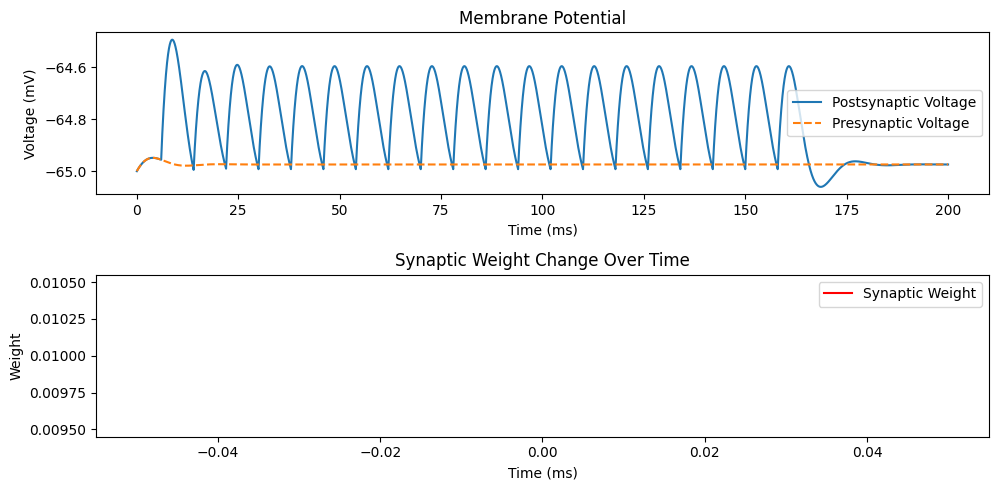

Final synaptic weight: 0.01


In [15]:


# Create pre- and post-synaptic neurons
pre_neuron = h.Section(name='pre_neuron')
post_neuron = h.Section(name='post_neuron')

# Insert Hodgkin-Huxley mechanism
pre_neuron.insert('hh')
post_neuron.insert('hh')

# Create a synapse on the postsynaptic neuron
syn = h.ExpSyn(post_neuron(0.5))
syn.tau = 5  # Decay time (ms)

# Create a NetStim to generate presynaptic spikes
stim = h.NetStim()
stim.start = 5   # First spike at 5 ms
stim.number = 20  # Number of spikes
stim.interval = 8  # Spike interval (ms)

# Connect the stimulator to the synapse via NetCon
nc = h.NetCon(stim, syn)
nc.weight[0] = 0.01  # Initial synaptic weight
nc.delay = 1  # Delay in ms

# Record membrane potential
v_pre = h.Vector().record(pre_neuron(0.5)._ref_v)
v_post = h.Vector().record(post_neuron(0.5)._ref_v)
t = h.Vector().record(h._ref_t)

# Record synaptic weight
weights = h.Vector()

def record_weight():
    """ Function to store synaptic weight over time """
    weights.append(nc.weight[0])
    h.cvode.event(h.t + 0.5, record_weight)  # Schedule next recording

record_weight()  # Start recording

# ** STDP Mechanism **
def stdp_rule(nc, delta_t):
    print(f"Δt: {delta_t}, New Weight: {nc.weight[0]}")

    """ Spike-Timing-Dependent Plasticity Rule """
    tau_plus = 20  # LTP time constant (ms)
    tau_minus = 20  # LTD time constant (ms)
    A_plus = 0.01  # Max LTP change
    A_minus = 0.01  # Max LTD change

    if delta_t > 0:  # Pre before post → LTP
        nc.weight[0] += A_plus * np.exp(-delta_t / tau_plus)
    else:  # Post before pre → LTD
        nc.weight[0] -= A_minus * np.exp(delta_t / tau_minus)

    nc.weight[0] = max(0, nc.weight[0])  # Ensure non-negative weight

# Spike detection for STDP
def detect_spikes(vec, threshold=-40):
    """ Detect spike times in a voltage vector """
    return [t[i] for i in range(1, len(vec)-1) if vec[i-1] < threshold < vec[i+1]]

# Run simulation
h.finitialize(-65)
h.continuerun(200)

# Apply STDP rule dynamically during simulation
def apply_stdp():
    pre_spikes = detect_spikes(v_pre)
    print("Pre spiked: ", pre_spikes)
    post_spikes = detect_spikes(v_post)

    for pre_t in pre_spikes:
        for post_t in post_spikes:
            stdp_rule(nc, pre_t - post_t)

    h.cvode.event(h.t + 1, apply_stdp)  # Schedule next check

apply_stdp()  # Start applying STDP dynamically


# ** Plot results **

plt.figure(figsize=(10, 5))

# Plot membrane potential
plt.subplot(2, 1, 1)
plt.plot(t, v_post, label="Postsynaptic Voltage")
plt.plot(t, v_pre, label="Presynaptic Voltage", linestyle="dashed")
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (mV)")
plt.legend()
plt.title("Membrane Potential")

# Plot synaptic weight over time
plt.subplot(2, 1, 2)
plt.plot(weights, label="Synaptic Weight", color="r")
plt.xlabel("Time (ms)")
plt.ylabel("Weight")
plt.legend()
plt.title("Synaptic Weight Change Over Time")

plt.tight_layout()
plt.show()

print("Final synaptic weight:", nc.weight[0])


Pre-spike times: []
Post-spike times: []


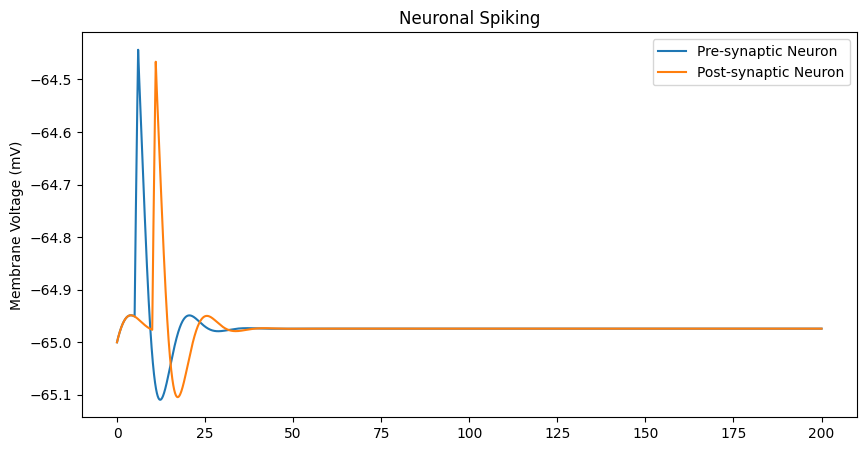

Weight changes: []
No weight changes recorded!


In [66]:
import matplotlib.pyplot as plt
import numpy as np
from neuron import h

# Create a simple neuron model (for demonstration)
h.load_file("stdrun.hoc")

# Create two neurons
pre_neuron = h.Section(name="pre_neuron")
pre_neuron.insert("hh")  # Insert Hodgkin-Huxley model into the pre-synaptic neuron

post_neuron = h.Section(name="post_neuron")
post_neuron.insert("hh")  # Insert Hodgkin-Huxley model into the post-synaptic neuron


# Set initial weight for the synapse
initial_weight = 0.01

# Create synapses and connections
syn = h.ExpSyn(post_neuron(0.5))  # Synapse at the middle of the post_neuron
syn.tau = 2  # Synaptic time constant

# Create a stimulus to pre and post neurons
stim_pre = h.IClamp(pre_neuron(0.5))
stim_pre.amp = 1.0  # Amplitude of pre-synaptic stimulus
stim_pre.dur = 1  # Duration of the stimulus
stim_pre.delay = 5  # Pre-synaptic spike at 5ms

stim_post = h.IClamp(post_neuron(0.5))
stim_post.amp = 1.0  # Amplitude of post-synaptic stimulus
stim_post.dur = 1  # Duration of the stimulus
stim_post.delay = 10  # Post-synaptic spike at 10ms

# Create lists to track spike times
pre_spikes = []
post_spikes = []

# Create a class to handle STDP
class STDP:
    def __init__(self):
        self.pre_times = []
        self.post_times = []
        self.weight_changes = []
        self.weight = initial_weight  # Initial weight

    def pre_spike(self, t):
        print(f"Pre-synaptic spike at {t} ms")
        self.pre_times.append(t)
        self.update_weights()
        pre_spikes.append(t)

    def post_spike(self, t):
        print(f"Post-synaptic spike at {t} ms")
        self.post_times.append(t)
        self.update_weights()
        post_spikes.append(t)

    def update_weights(self):
        print(f"Pre time: {self.pre_times[-1]}, Post time: {self.post_times[-1]}, dt: {dt}")

        # Make sure we have both pre and post spikes
        if len(self.pre_times) > 0 and len(self.post_times) > 0:
            dt = self.post_times[-1] - self.pre_times[-1]  # Time difference

            # LTP condition (pre-before-post)
            if dt > 0 and dt < 10:  # Use a small time window for LTP
                self.weight += 0.005 * (1 - self.weight)  # Increase the weight
                print(f"LTP: Updated weight to {self.weight}")
            # LTD condition (post-before-pre)
            elif dt < 0 and dt > -10:  # Use a small time window for LTD
                self.weight -= 0.005 * self.weight  # Decrease the weight
                print(f"LTD: Updated weight to {self.weight}")

            # Keep the weight within a valid range
            self.weight = max(0, min(self.weight, 0.1))  # Restrict weight to [0, 0.1]
            self.weight_changes.append((h.t, self.weight))  # Store weight change

# Instantiate STDP
stdp = STDP()

# Record spikes
pre_spikes = h.Vector()
post_spikes = h.Vector()


# Set up spike detectors (for recording spikes)
pre_netcon = h.NetCon(pre_neuron(0.5)._ref_v, None, sec=pre_neuron)
post_netcon = h.NetCon(post_neuron(0.5)._ref_v, None, sec=post_neuron)
#netcon_pre.threshold = -20  # Pre-synaptic spike threshold
#netcon_post.threshold = -20  # Post-synaptic spike threshold

# Set netcons to call STDP functions
#pre_netcon.record(stdp.pre_spike)  # Call pre_spike when a pre-synaptic spike happens
#post_netcon.record(stdp.post_spike)  # Call post_spike when a post-synaptic spike happens
pre_netcon.record(pre_spikes)
post_netcon.record(post_spikes)

# Record voltage and weight changes
t = h.Vector().record(h._ref_t)
v_pre = h.Vector().record(pre_neuron(0.5)._ref_v)
v_post = h.Vector().record(post_neuron(0.5)._ref_v)


# Run the simulation
#h.tstop = 20  # Stop the simulation after 20ms to allow for 2 spikes
#h.run()
# Run simulation
h.finitialize(-65)
h.continuerun(200)

for t_spike in pre_spikes:
    stdp.pre_spike(t_spike)

for t_spike in post_spikes:
    stdp.post_spike(t_spike)


print("Pre-spike times:", list(pre_spikes))
print("Post-spike times:", list(post_spikes))


# Convert data to NumPy arrays
t_np = np.array(t)
v_pre_np = np.array(v_pre)
v_post_np = np.array(v_post)
weights = np.array(stdp.weight_changes)

# Plot Voltage Traces
plt.figure(figsize=(10, 5))
plt.plot(t_np, v_pre_np, label="Pre-synaptic Neuron")
plt.plot(t_np, v_post_np, label="Post-synaptic Neuron")
plt.legend()
plt.ylabel("Membrane Voltage (mV)")
plt.title("Neuronal Spiking")
plt.show()



# Plot weight changes
weights = np.array(stdp.weight_changes)
print("Weight changes:", weights)

# If weight changes exist, plot the weight updates over time
if len(weights) > 0:
    times, weight_values = zip(*weights)  # Unpack the time and weight values
    times = np.array(times)
    weight_values = np.array(weight_values)

    # Plot the initial weight as a horizontal line
    plt.plot([times[0]] * 2, [initial_weight, weight_values[0]], linestyle='-', color='red', label="Initial Weight")

    # Plot the weight changes after STDP
    plt.plot(times, weight_values, marker='o', linestyle='-', color='blue', label="Synaptic Weight")

    plt.xlabel("Time (ms)")
    plt.ylabel("Synaptic Weight")
    plt.title("Synaptic Weight Change due to STDP")
    plt.legend()
    plt.show()
else:
    print("No weight changes recorded!")


# Code

LTD:  -5e-05
LTP:  0.00045025
LTD:  -5.200125e-05
Pre-spike times: [20.925000000099345, 42.900000000101194, 61.900000000105514]
Post-spike times: [15.92500000009963, 45.92500000010188, 57.17500000010444]


<Figure size 1000x500 with 0 Axes>

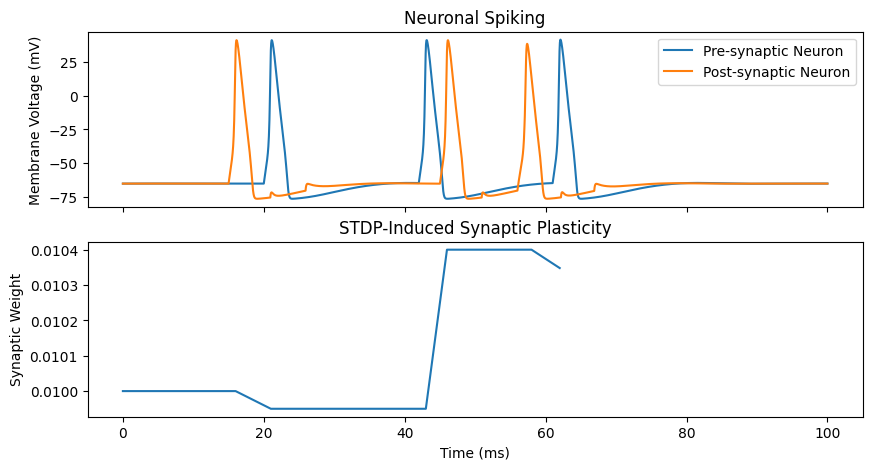

In [19]:
# Create pre- and post-synaptic neurons
pre_neuron = h.Section(name='pre_neuron')
post_neuron = h.Section(name='post_neuron')

# Set neuron properties
for sec in [pre_neuron, post_neuron]:
    sec.L = sec.diam = 20  # Soma
    sec.insert('hh')  # Hodgkin-Huxley channels

# Create a synapse on the post-neuron
syn = h.ExpSyn(post_neuron(0.5))
#syn.tau = 2  # Rise time (ms)
#syn.tau2 = 5  # Decay time (ms)
syn.e = 0  # Reversal potential (mV)

# Connect the neurons with a NetCon
initial_weight = 0.01
max_weight = 0.1
delay = 5 # Delay in ms
pre_netcon = h.NetCon(pre_neuron(0.5)._ref_v, syn, sec=pre_neuron)
pre_netcon.weight[0] = initial_weight  # Initial synaptic weight
pre_netcon.delay = delay
post_netcon = h.NetCon(post_neuron(0.5)._ref_v, syn, sec=post_neuron)
post_netcon.weight[0] = initial_weight  # Initial synaptic weight
post_netcon.delay = delay

class STDP:
    def __init__(self, netcon):
        self.netcon = netcon
        self.weight = netcon.weight[0]  # Synaptic weight
        self.pre_times = []
        self.post_times = []
        self.dt_LTP = 10  # Time window for LTP (ms)
        self.dt_LTD = -10  # Time window for LTD (ms)
        self.A_plus = 0.005  # LTP increment
        self.A_minus = -0.005  # LTD decrement
        self.weight_changes = []

    def pre_spike(self, t):
        #print(f"Pre-synaptic spike at {t} ms")
        self.pre_times.append(t)
        self.update_weights()

    def post_spike(self, t):
        #print(f"Post-synaptic spike at {t} ms")
        self.post_times.append(t)
        self.update_weights()

    def update_weights(self):
        if len(self.pre_times) > 0 and len(self.post_times) > 0:
            dt = self.post_times[-1] - self.pre_times[-1]  # Time difference

            if dt > 0 and dt < self.dt_LTP:  # LTP Condition
                print("LTP: ", self.A_plus * (max_weight - self.weight))
                self.weight += self.A_plus * (max_weight - self.weight)
            elif dt < 0 and dt > self.dt_LTD:  # LTD Condition
                print("LTD: ", self.A_minus * self.weight)
                self.weight += self.A_minus * self.weight

            self.weight = max(0, min(self.weight, max_weight))  # Keep weight within limits
            self.netcon.weight[0] = self.weight
            self.weight_changes.append((h.t, self.weight))

stdp = STDP(pre_netcon)

# Record spikes
pre_spikes = h.Vector()
post_spikes = h.Vector()

pre_netcon.record(pre_spikes)
post_netcon.record(post_spikes)

# Stimulate Pre-Synaptic Neuron
stim_pre = h.IClamp(pre_neuron(0.5))
stim_pre.delay = 20
stim_pre.dur = 1
stim_pre.amp = 0.5

stim_pre2 = h.IClamp(pre_neuron(0.5))
stim_pre2.delay = 42
stim_pre2.dur = 1
stim_pre2.amp = 0.5

stim_pre3 = h.IClamp(pre_neuron(0.5))
stim_pre3.delay = 61
stim_pre3.dur = 1
stim_pre3.amp = 0.5

# Stimulate Post-Synaptic Neuron (to induce pairing)
stim_post = h.IClamp(post_neuron(0.5))
stim_post.delay = 15  # Post fires shortly after Pre to induce LTP
stim_post.dur = 1
stim_post.amp = 0.5

stim_post2 = h.IClamp(post_neuron(0.5))
stim_post2.delay = 45
stim_post2.dur = 1
stim_post2.amp = 0.5

stim_post3 = h.IClamp(post_neuron(0.5))
stim_post3.delay = 56
stim_post3.dur = 1
stim_post3.amp = 0.5

# Record voltage and weight changes
t = h.Vector().record(h._ref_t)
v_pre = h.Vector().record(pre_neuron(0.5)._ref_v)
v_post = h.Vector().record(post_neuron(0.5)._ref_v)


# Run simulation
h.finitialize(-65)

# Continuously run the simulation and update weights during the simulation
while h.t < 100:
    h.continuerun(h.t + 1)  # Incrementally run the simulation
    # Call pre_spike and post_spike whenever spikes are detected
    for t_spike in pre_spikes:
        #print("t_spike ", t_spike)
        #print("h.t ", h.t)
        if (t_spike > h.t-1): # only process newly detected spikes
          stdp.pre_spike(t_spike)

    for t_spike in post_spikes:
        if (t_spike > h.t-1): # only process newly detected spikes
          stdp.post_spike(t_spike)

# Convert data to NumPy arrays
t_np = np.array(t)
v_pre_np = np.array(v_pre)
v_post_np = np.array(v_post)
weights = np.array(stdp.weight_changes)


# Add initial weight at time 0ms until (first weight_change - delay)
init_weight_start = np.array([[0, initial_weight]])
init_weight_end = np.array([[weights[0,0] - delay, initial_weight]])
weights = np.vstack([init_weight_start, init_weight_end, weights])

print("Pre-spike times:", list(pre_spikes))
print("Post-spike times:", list(post_spikes))
#print("Weights:", weights)

# Plot Voltage Traces
plt.figure(figsize=(10, 5))
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 5))
#plt.subplot(2,1,1)
ax1.plot(t_np, v_pre_np, label="Pre-synaptic Neuron")
ax1.plot(t_np, v_post_np, label="Post-synaptic Neuron")
ax1.legend()
ax1.set_ylabel("Membrane Voltage (mV)")
ax1.set_title("Neuronal Spiking")

# Plot Synaptic Weight Changes
if len(weights) > 0:
  #ax2.subplot(2,1,2)
  ax2.plot(weights[:,0], weights[:,1])
  ax2.set_xlabel("Time (ms)")
  #ax2.set_ylim(bottom=0.0098)
  #ax2.set_ylim(top=0.0101)
  ax2.set_ylabel("Synaptic Weight")
  ax2.set_title("STDP-Induced Synaptic Plasticity")
else:
    print("No weight changes recorded!")

#plt.tight_layout()
plt.show()


